# CEE 690-02

# Environmental Spatial Data Analysis

# Regression Kriging

# Outline

* Regression Kriging
* Conditional simulations

# Simple and Ordinary Kriging

Until now we have assumed that:
    
$$Z(\mathbf{x}) = \mu + e(\mathbf{x})$$

Where $\mu$ is the spatially constant mean and $e(\mathbf{x})$ is a random variable with mean 0.

When using Simple Kriging we assume to know $\mu$ while in Ordinary Kriging we don't.

# Drop the assumption of constant mean

What if the spatial mean has a trend? In other words, what if $\mu(\mathbf{x})$ is also spatially varying (albeit smoother)?

$$Z(\mathbf{x}) = \mu(\mathbf{x}) + e(\mathbf{x})$$

We can no longer use Simple Kriging or Ordinary Kriging. 

Addressing this issue was the original idea behing Universal Kriging (which we won't talk about). 

Instead we will discuss a contemporary idea called Regression Kriging.

# Main idea: Split into a deterministic and random component

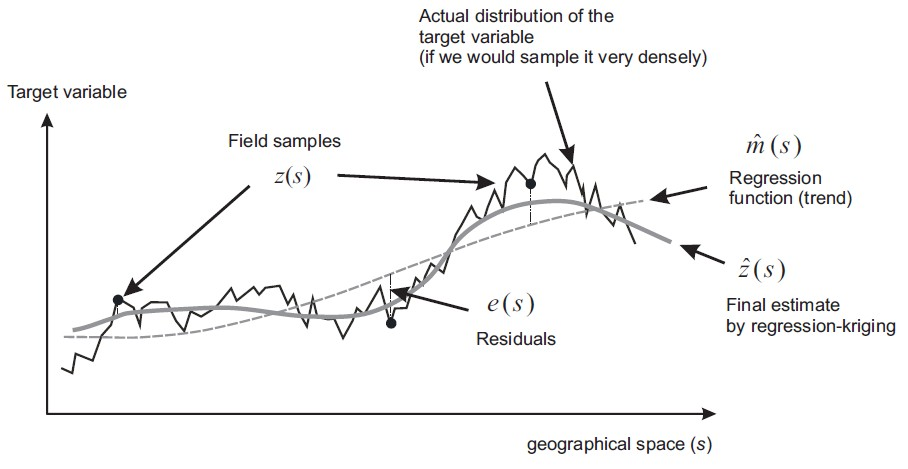

# Another way to see this...

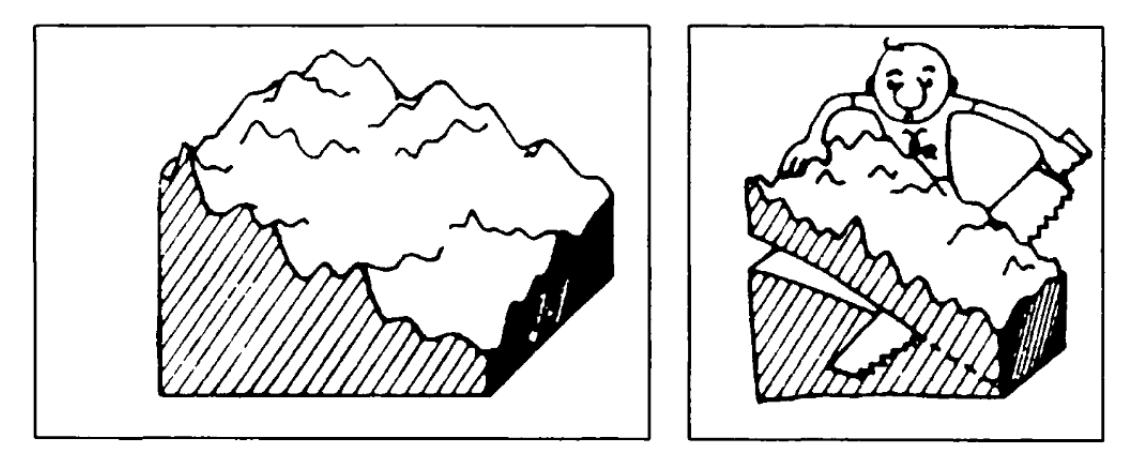

Any ideas on how we could estimate the deterministic component $\mu(\mathbf{x})$?

# Answer: Regression!

For example one could use a Random Forest regressor to estimate $\mu(\mathbf{x})$ and then use Ordinary/Simple Kriging to estimate $e(\mathbf{x})$.

Hence the term **Regression Kriging**.

# Let's  explore Regression Kriging

In [1]:
import xarray as xr
import numpy as np
fp = xr.open_rasterio('../Workspace/sand_0_5.tif')
data = np.array(fp[0,:,:])
y = np.array(fp['y'][:])
x = np.array(fp['x'][:])
fp.close()

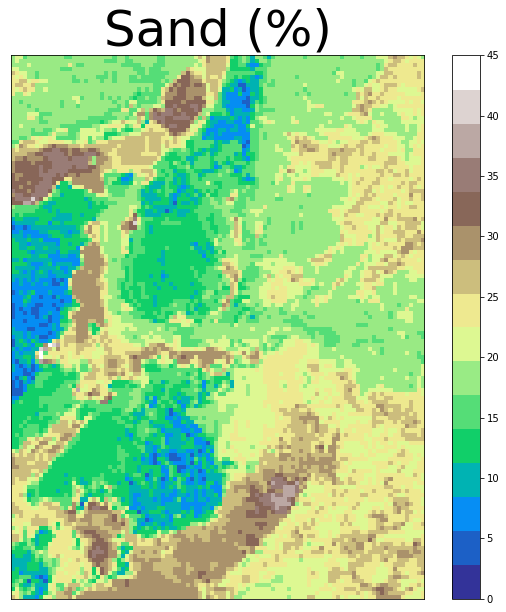

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
data = np.ma.masked_array(data,data<0)
vmin = 0
vmax = 45
plt.figure(figsize=(10,10))
plt.imshow(data,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
plt.colorbar()
plt.show()

# What are we going to try to prove?

Combining Regression and Kriging into a single framework generally outperforms using them independently.

# Let's sample some points

Note that I have decreased the sample size to be more consistent with real world data

In [15]:
#Let's randomly sample n different points
nsamples = int(0.005*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(10)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
#ipoints = np.arange(x.size*y.size)[::125]
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Assemble the points
yt = []
for i in range(iy.size):
    yt.append(data[iy[i],ix[i]])
yt = np.array(yt)

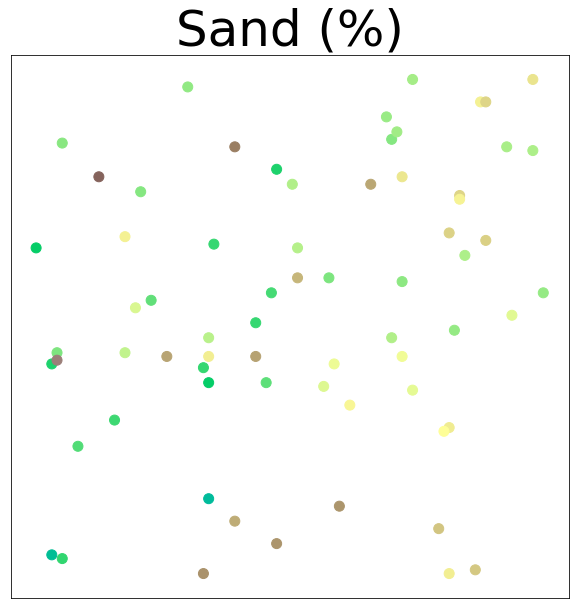

In [16]:
#Make a scatter plot of the data
plt.figure(figsize=(10,10))
plt.scatter(ix,np.max(iy)-iy,c=yt,s=100,vmin=0,vmax=45,cmap='terrain')
plt.xticks([])
plt.yticks([])
plt.title('Sand (%)',fontsize=50)
plt.show()

# Regression Kriging

Let's start with the Regression component

# Random Forest Regression

In [6]:
%%bash
#Extract region
gdalwarp -r average -overwrite -te -89.8 40.3 -89.5 40.6 /data/NED/NED.vrt ../Workspace/tmp.tif
gdalwarp -r average -overwrite -r average -tr 250 250 -t_srs '+proj=aea +lat_1=40.0 +lat_2=41.0 +lat_0=40.5 +lon_0=-90 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/dem.tif
#Extract region
gdalwarp -r average -overwrite -r lanczos -tr 0.000277777 0.000277777 -te -89.8 40.3 -89.5 40.6 -t_srs EPSG:4326 /data/AERO/NArad_K_geog83.tif ../Workspace/tmp.tif
gdalwarp -r average -overwrite -r average -tr 250 250 -t_srs '+proj=aea +lat_1=40.0 +lat_2=41.0 +lat_0=40.5 +lon_0=-90 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/gammaK.tif
#Extract region
gdalwarp -r average -overwrite -r lanczos -tr 0.000277777 0.000277777 -te -89.8 40.3 -89.5 40.6 -t_srs EPSG:4326 /data/AERO/NArad_Th_geog83.tif ../Workspace/tmp.tif
gdalwarp -r average -overwrite -r average -tr 250 250 -t_srs '+proj=aea +lat_1=40.0 +lat_2=41.0 +lat_0=40.5 +lon_0=-90 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/gammaTh.tif
#Extract region
gdalwarp -r average -overwrite -r lanczos -tr 0.000277777 0.000277777 -te -89.8 40.3 -89.5 40.6 -t_srs EPSG:4326 /data/AERO/NArad_U_geog83.tif ../Workspace/tmp.tif
gdalwarp -r average -overwrite -r average -tr 250 250 -t_srs '+proj=aea +lat_1=40.0 +lat_2=41.0 +lat_0=40.5 +lon_0=-90 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/gammaU.tif
#Extract region
gdalwarp -r average -overwrite -r lanczos -tr 0.000277777 0.000277777 -te -89.8 40.3 -89.5 40.6 -t_srs EPSG:4326 /data/NLCD/NLCD_2016_Tree_Canopy_L48/NLCD_2016_Tree_Canopy_L48_20190831.img ../Workspace/tmp.tif
gdalwarp -r average -overwrite -r average -tr 250 250 -t_srs '+proj=aea +lat_1=40.0 +lat_2=41.0 +lat_0=40.5 +lon_0=-90 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' ../Workspace/tmp.tif ../Workspace/nlcd_tcf.tif

Creating output file that is 1080P x 1080L.
Processing /data/NED/NED.vrt [1/1] : 0Using internal nodata values (e.g. -99999) for image /data/NED/NED.vrt.
Copying nodata values from source /data/NED/NED.vrt to destination ../Workspace/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 102P x 134L.
Processing ../Workspace/tmp.tif [1/1] : 0Using internal nodata values (e.g. -99999) for image ../Workspace/tmp.tif.
Copying nodata values from source ../Workspace/tmp.tif to destination ../Workspace/dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1080P x 1080L.
Processing /data/AERO/NArad_K_geog83.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 102P x 134L.
Processing ../Workspace/tmp.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1080P x 1080L.
Processing /data/AERO/NArad_Th_geog83.tif [1/1

pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_create: Open of /opt/conda/share/proj failed
pj_obj_creat

In [17]:
import rasterio
vars = ['dem','gammaK','gammaTh','gammaU','nlcd_tcf']#,'x','y']
X = []
for var in vars:
    #if var == 'x':X.append(xs.reshape(xs.size))
    #elif var == 'y':X.append(ys.reshape(ys.size))
    tmp = rasterio.open('../Workspace/%s.tif' % var).read(1)
    X.append(tmp.reshape(tmp.size))
X = np.array(X).T

# Environmental predictors

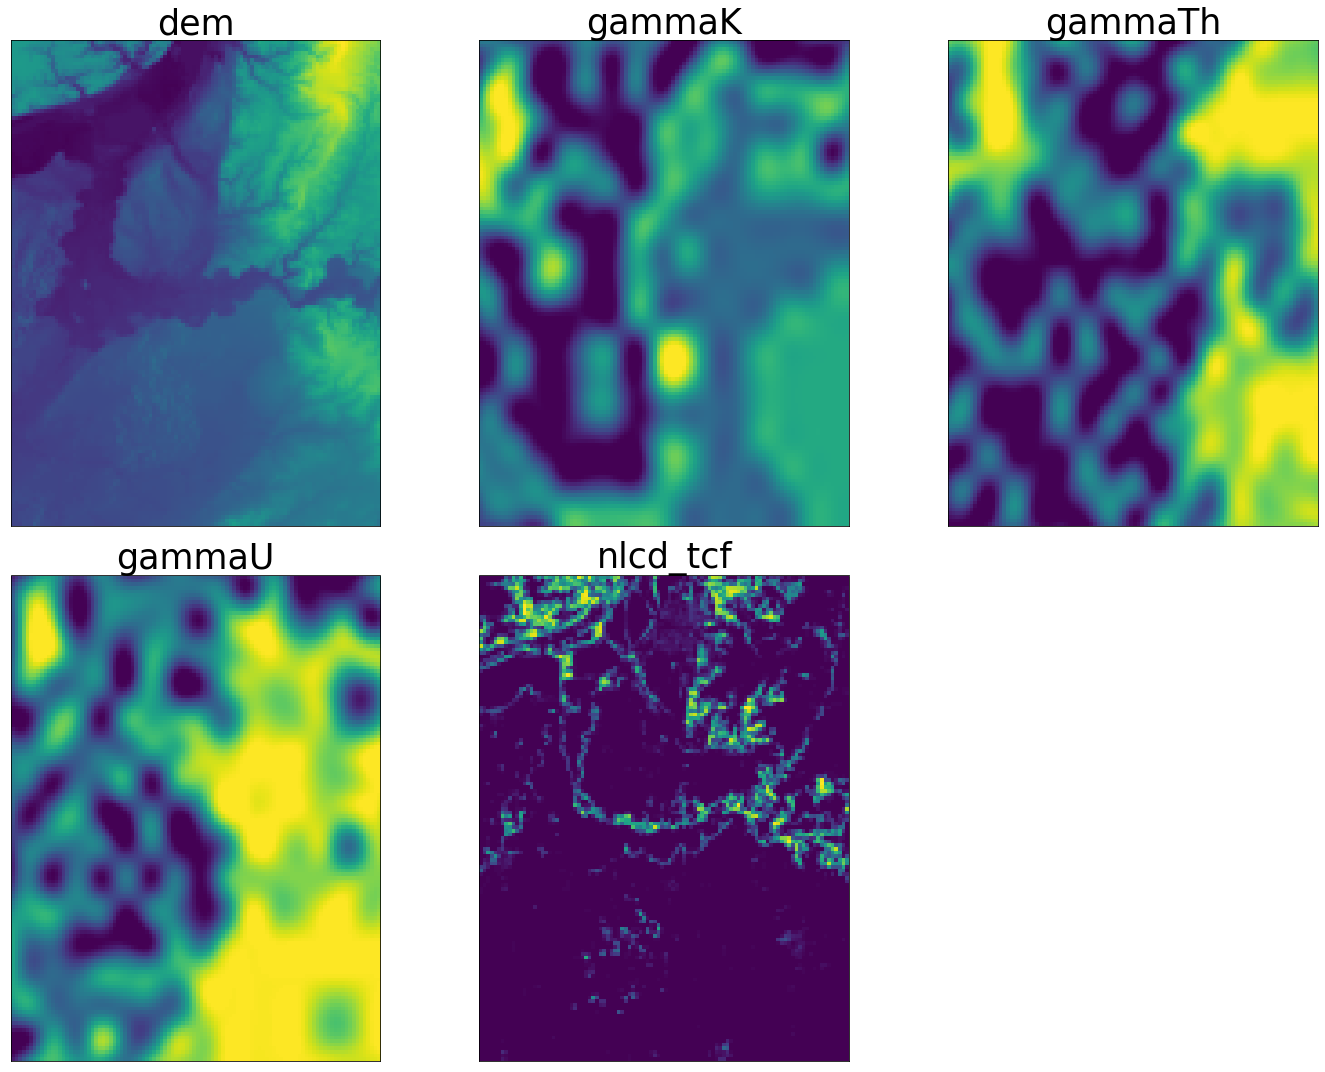

In [18]:
plt.figure(figsize=(20,15))
for var in vars:
    plt.subplot(2,3,vars.index(var)+1)
    plt.imshow(X[:,vars.index(var)].reshape(data.shape))
    plt.xticks([])
    plt.yticks([])
    plt.title(var,fontsize=35)
plt.tight_layout()
plt.show()

In [19]:
# Assemble training and validation dataset
#Let's randomly sample n different points
nsamples = int(0.005*(x.size*y.size))
#Randomly sample n points on the domain
np.random.seed(1)
(xs,ys) = np.meshgrid(np.arange(x.size),np.arange(y.size))
ipoints = np.random.choice(np.arange(x.size*y.size),nsamples,replace=False)
#ipoints = np.arange(x.size*y.size)[::125]
ix = xs.ravel()[ipoints]
iy = ys.ravel()[ipoints]
#Extract the points
y_points = y[iy]
x_points = x[ix]
#Assemble the validation dataset
yt = []
Xt = []
for i in range(iy.size):
    yt.append(data[iy[i],ix[i]])
Xt = X[ipoints,:]
yt = np.array(yt)
#Assemble the test dataset
m = np.zeros(X.shape[0]).astype(np.bool)
m[ipoints] = 1
Xv = X[~m,:]
yv = data.reshape(data.size)[~m]

# Fit and evaluate Random Forest

In [20]:
import sklearn.ensemble
import sklearn.metrics
import sklearn.linear_model
clf = sklearn.ensemble.RandomForestRegressor(n_estimators=100,random_state=1)
clf.fit(Xt,yt)
yv_pred_rf = clf.predict(Xv)
print('R2: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_rf))

R2: 0.30


# Random Forest: Visual Comparison

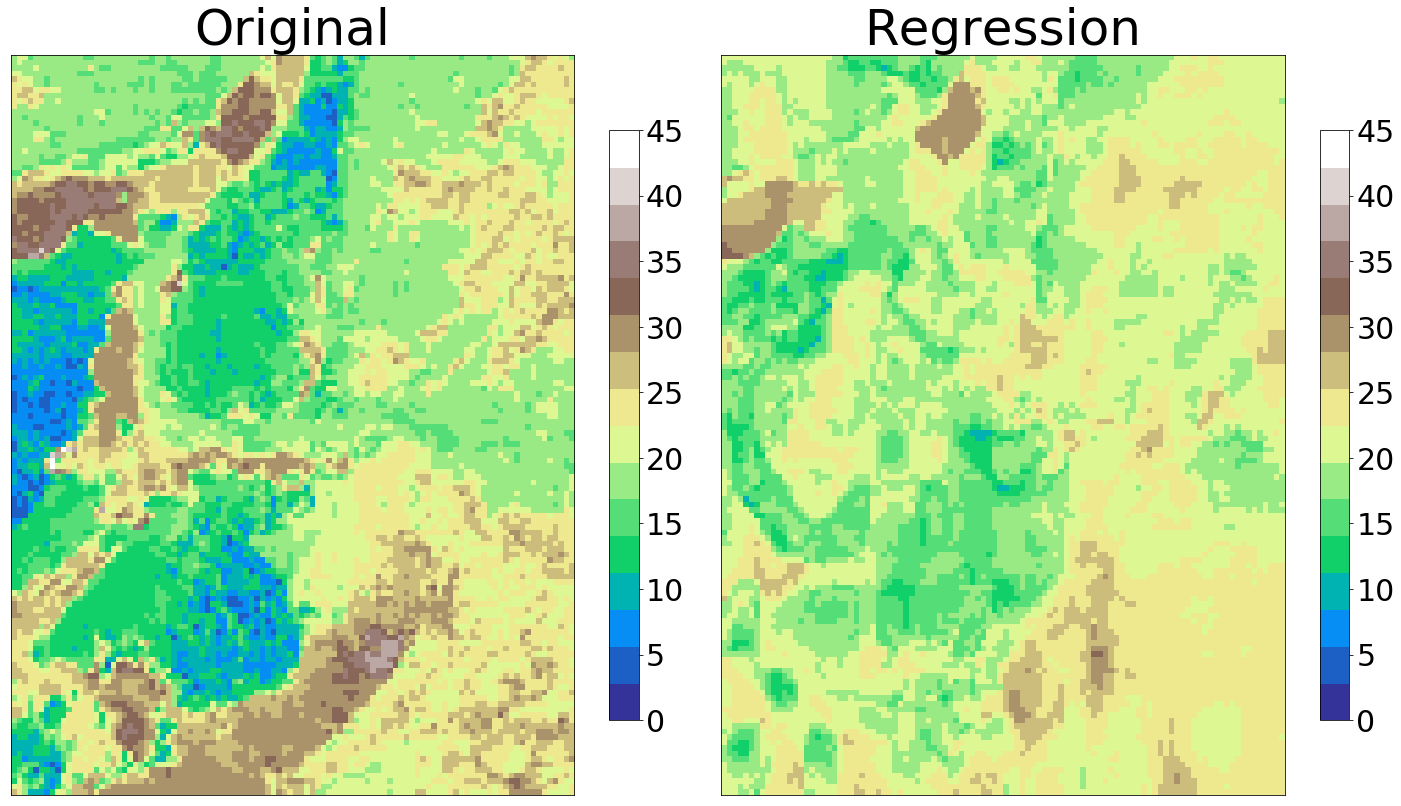

In [22]:
import matplotlib.cm as cm
vmin = 0
vmax = 45
ypred = clf.predict(X)
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred.reshape(data.shape),cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Regression',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

# Ordinary Kriging solution

In [23]:
import scipy.optimize

def sample_variogram(x_points,y_points,data_points):
    
    #Compute euclidean distances from observatins to observations
    h = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5

    # Compute variogram cloud by comparing all points
    gamma_c = (data_points[:,np.newaxis].T - data_points[:,np.newaxis])**2/2

    #Reshape to 1d arrays
    h = h.reshape(h.size)
    gamma_c = gamma_c.reshape(gamma_c.size)
    
    #Define delta
    delta = 1000 #m

    #Define bin edges
    bin_edges = np.linspace(0,20000,20000/delta+1)

    #Compute the center of each bin
    hd = (bin_edges[1:] + bin_edges[0:-1])/2

    #Compute sample semivariogram
    gamma_s = []
    for i in range(hd.size):
        if i == 0:m = (h >= bin_edges[i]) & (h < bin_edges[i+1])
        else:m = (h > bin_edges[i]) & (h <= bin_edges[i+1])
        tmp = np.mean(gamma_c[m])
        gamma_s.append(tmp)
    gamma_s = np.array(gamma_s)
    
    return(hd,gamma_s)

def exponential_semivariogram(h,c,tau):
    return c * (1 - np.exp(-h/tau))

def fit_exponential_semivariogram(hd,gamma_s):
    popt, pcov = scipy.optimize.curve_fit(exponential_semivariogram,hd,gamma_s,bounds=([0,1000],[100,25000]))
    #print('sill (c): %.2f' % popt[0])
    #print('range (tau): %.2f' % popt[1])
    return popt

# 1. Assemble the semivariogram model

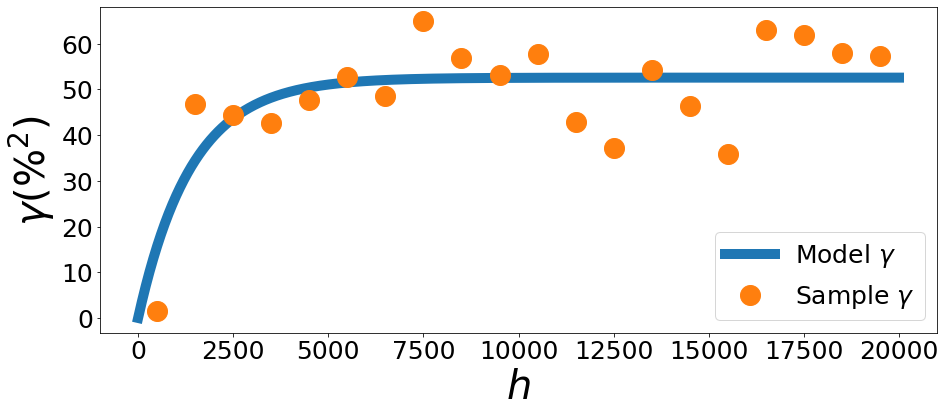

In [24]:
#Compute sample semivariogram
(hd,gamma_s) = sample_variogram(x_points,y_points,yt)
#Fit exponential semivariogram
vgfit = fit_exponential_semivariogram(hd,gamma_s)
#Make a plot
plt.figure(figsize=(15,6))
plt.plot(np.linspace(0,20000,1000),exponential_semivariogram(np.linspace(0,20000,1000),*vgfit),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Model $\gamma$',r'Sample $\gamma$'],fontsize=25)
plt.show()

# 2. Ordinary kriging

In [25]:
def ordinary_kriging(popt,x,y,x_points,y_points,zt):

    #Define variance
    var = popt[0]
    #Define tau
    tau = popt[1]
    #Define the meshgrid
    (x_grid,y_grid) = np.meshgrid(x,y)
    #Define grid positioning
    #Let's reshape our data to a 1d array
    xg1d = x_grid.reshape(x_grid.size)
    yg1d = y_grid.reshape(y_grid.size)
    #Compute euclidean distances from observations to points on grid
    dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5
    #Compute covariance matrix C
    C = var*np.exp(-dist/tau).T
    #Compute euclidean distances from observatins to observations
    dist = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5
    #Compute covariance matrix Sigma
    Sigma = var*np.exp(-dist/tau).T
    #Append the extra information for the langrange multipliers
    #Sigma_prime
    Sigma_prime = np.zeros((Sigma.shape[0]+1,Sigma.shape[1]+1))
    Sigma_prime[0:-1,0:-1] = Sigma[:]
    Sigma_prime[-1,0:-1] = 1
    Sigma_prime[0:-1,-1] = 1
    #C_prime
    C_prime = np.zeros((C.shape[0]+1,C.shape[1]))
    C_prime[0:-1,:] = C[:,:]
    C_prime[-1,:] = 1
    # Solve for the weights
    W = np.linalg.solve(Sigma_prime,C_prime)
    #Compute zstar
    zstar = np.sum(W[0:-1,:]*zt[:,np.newaxis],axis=0)
    #Compute mse 
    mse = var - np.sum(W[0:-1,:]*C_prime[0:-1,:],axis=0) - W[-1,:]
    
    return (zstar,mse)

In [26]:
(ypred,mse) = ordinary_kriging(vgfit,x,y,x_points,y_points,yt)
yv_pred_ok = ypred[~m]
print('R2: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_ok))

R2: 0.37


# Ordinary Kriging: Visual comparison

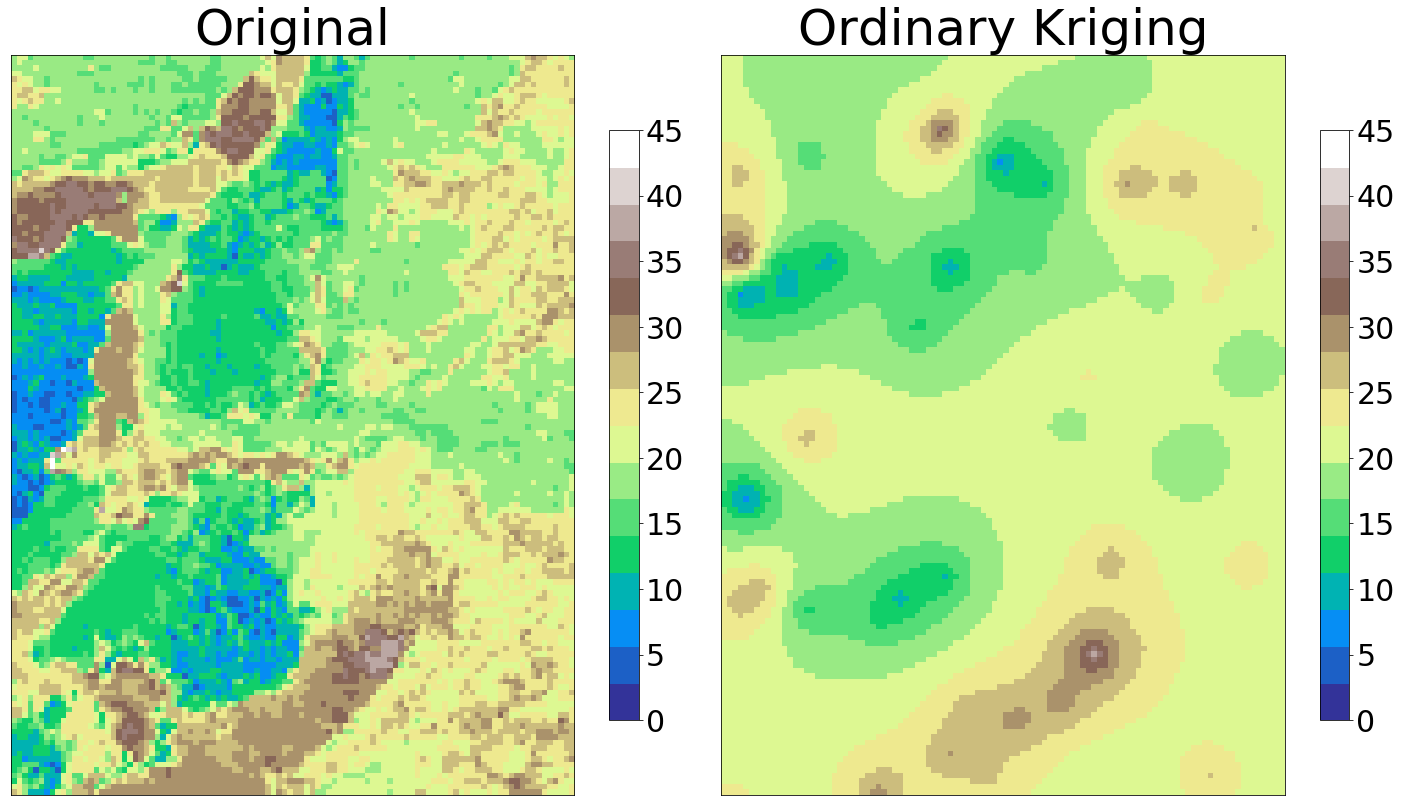

In [27]:
import matplotlib.cm as cm
vmin = 0
vmax = 45
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred.reshape(data.shape),cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Ordinary Kriging',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

# Let's combine Regression and Kriging now

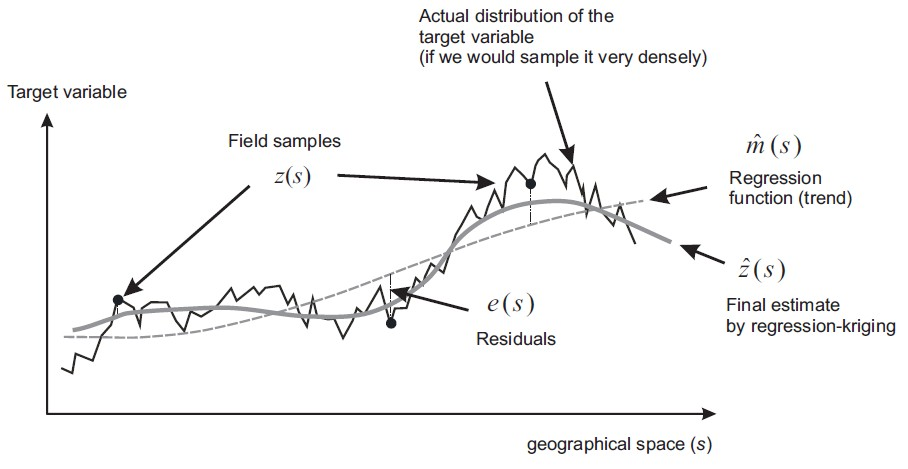

# Compute the residuals

In [28]:
rt = yt - clf.predict(Xt)

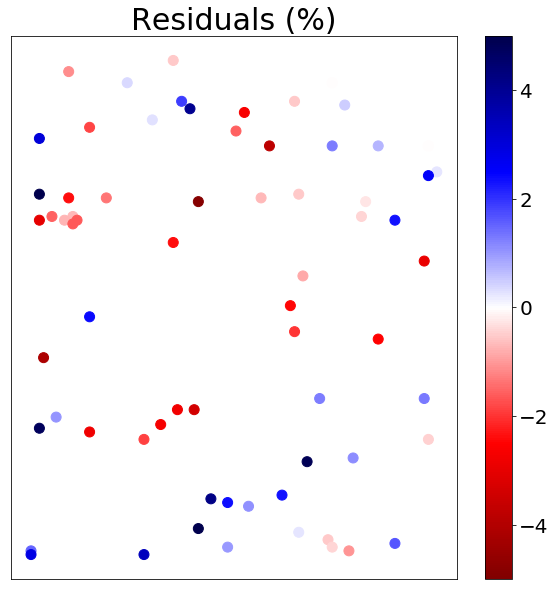

In [29]:
#Make a scatter plot of the data
plt.figure(figsize=(10,10))
plt.scatter(ix,np.max(iy)-iy,c=rt,s=100,vmin=-5,vmax=5,cmap='seismic_r')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.title('Residuals (%)',fontsize=30)
plt.show()

# Assemble semivariogram of residuals

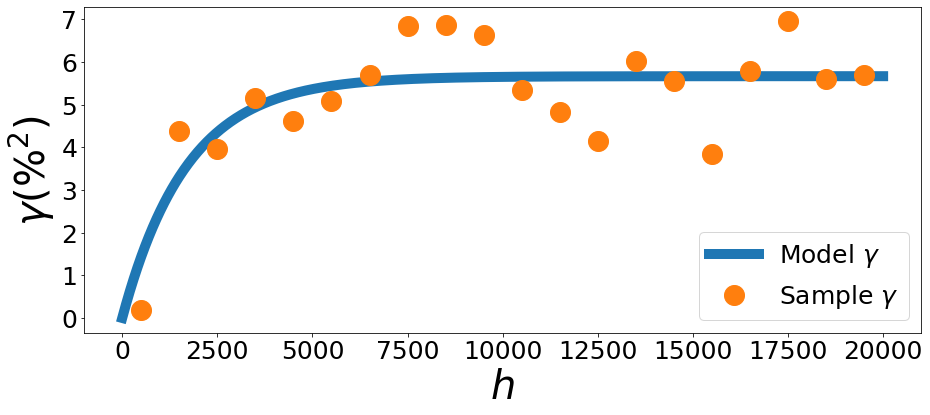

In [30]:
#Compute sample semivariogram
(hd,gamma_s) = sample_variogram(x_points,y_points,rt)
#Fit exponential semivariogram
vgfit = fit_exponential_semivariogram(hd,gamma_s)
#Make a plot
plt.figure(figsize=(15,6))
plt.plot(np.linspace(0,20000,1000),exponential_semivariogram(np.linspace(0,20000,1000),*vgfit),lw=10)
plt.plot(hd,gamma_s,'o',markersize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'$h$',fontsize=40)
plt.ylabel(r'$\gamma(\%^2)$',fontsize=40)
plt.legend([r'Model $\gamma$',r'Sample $\gamma$'],fontsize=25)
plt.show()

# Krige the residuals

In [31]:
(rpred,mse) = ordinary_kriging(vgfit,x,y,x_points,y_points,rt)

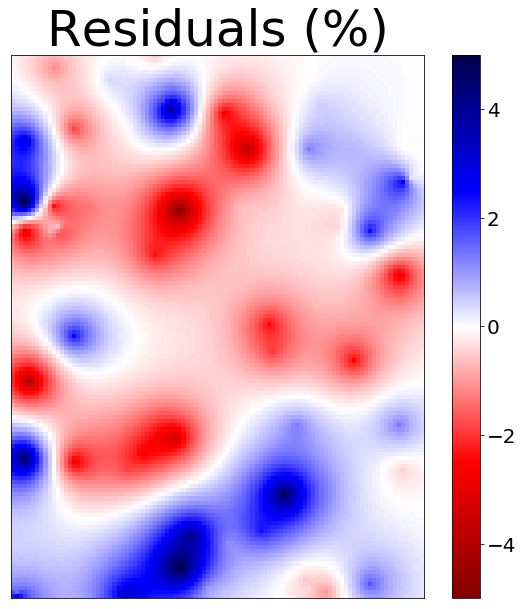

In [32]:
vmin = -5
vmax = 5
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.imshow(rpred.reshape(data.shape),cmap='seismic_r',vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Residuals (%)',fontsize=50)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.show()

# Add it all together

In [33]:
yv_pred_rf_ok = clf.predict(Xv) + rpred[~m]
print(sklearn.metrics.r2_score(yv,yv_pred_rf_ok))

0.3954122835855728


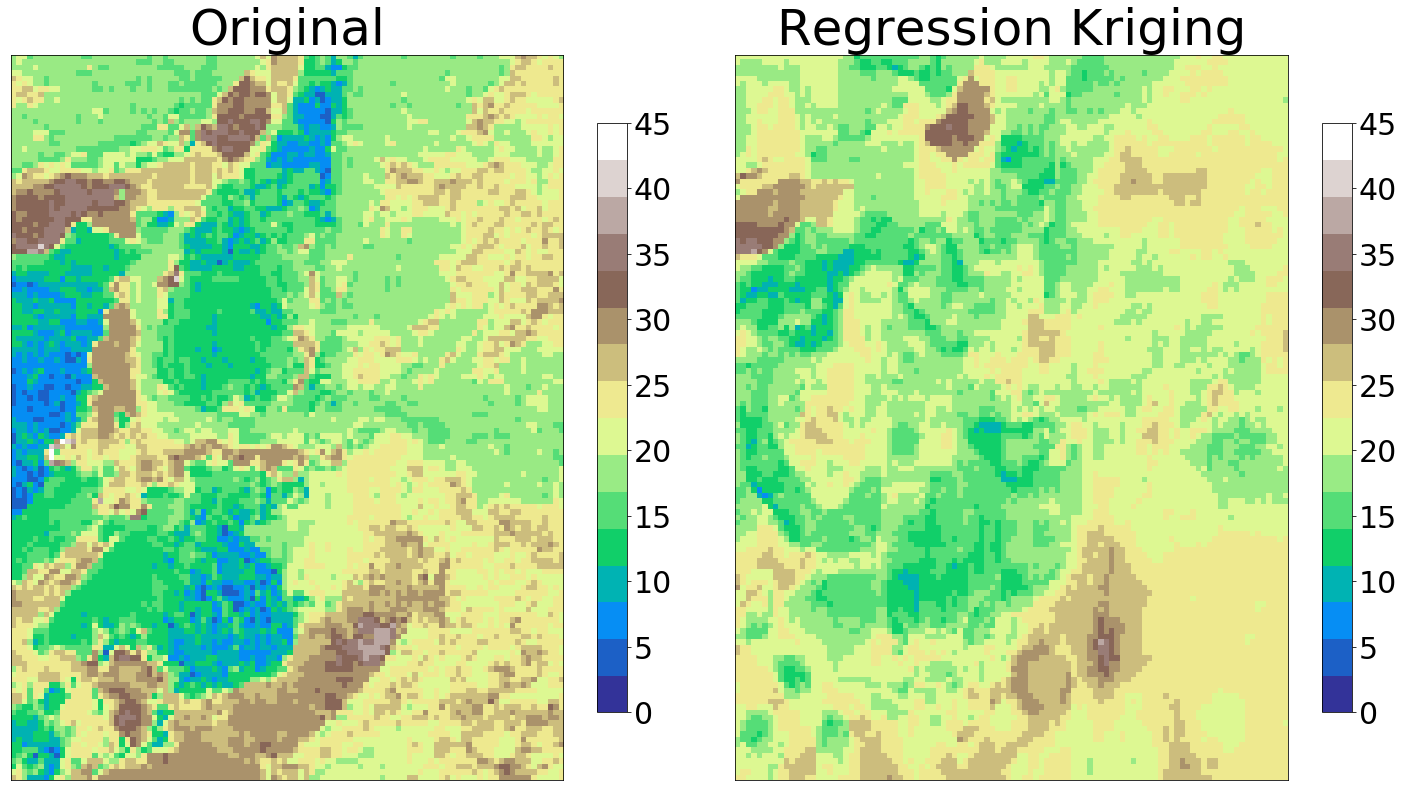

In [34]:
import matplotlib.cm as cm
vmin = 0
vmax = 45
ypred = clf.predict(X) + rpred
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred.reshape(data.shape),cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Regression Kriging',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

# Is Regression Kriging worth it?

In [35]:
print('Regression: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_rf))
print('Kriging: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_ok))
print('Regression Kriging: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_rf_ok))

Regression: 0.30
Kriging: 0.37
Regression Kriging: 0.40


# Conditional stochastic simulations

# Motivation: Looking at Kriging from a different perspective

We have been imagining the random field $Z$ as a set of different random variables $Z(\mathbf{x})$ that are interconnected through their covariances (Random Process).

If we assume that each $Z(\mathbf{x})$ is a univariate Gaussian, we are effectively interpreting $Z$ as an n-dimensional Gaussian distribution; where $n$ is the number of points or pixels (i.e., Gaussian Process).

Kriging with a constant mean is effectively taking a single prior distribution and conditioning it using nearby observations by harnessing the covariance information.

Under the assumption of second-order stationarity, if $Z(\mathbf{x})$ is a Gaussian, then the priors of all $Z_i$ are the same.

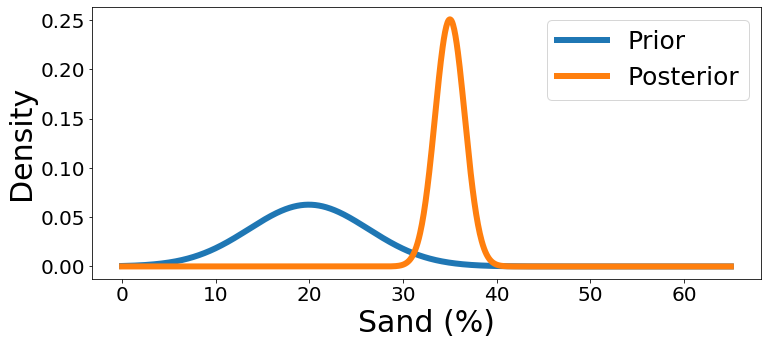

In [36]:
import scipy.stats
mu = np.mean(data) #% sand
var = np.var(data) #%^2 sand
xpdf = np.linspace(0,65,1000)
plt.figure(figsize=(12,5))
plt.plot(xpdf,scipy.stats.norm.pdf(xpdf,loc=mu,scale=var**0.5),lw=6)
plt.plot(xpdf,scipy.stats.norm.pdf(xpdf,loc=35,scale=var**0.5/4),lw=6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Density',fontsize=30)
plt.xlabel('Sand (%)',fontsize=30)
plt.legend(['Prior','Posterior'],fontsize=25)
plt.show()

# What does that have anything to do with stochastic simulations?

Everything!

# Simple Kriging example

In [37]:
def simple_kriging(vgfit,x,y,x_points,y_points,yt):
    #Extract parameters
    var = vgfit[0]
    tau = vgfit[1]
    #Calculate mean
    mu = np.mean(yt)
    #Define the meshgrid
    (x_grid,y_grid) = np.meshgrid(x,y)
    #Define grid positioning
    #Let's reshape our data to a 1d array
    xg1d = x_grid.reshape(x_grid.size)
    yg1d = y_grid.reshape(y_grid.size)
    #Compute euclidean distances from observations to points on grid
    dist = ((xg1d[:,np.newaxis] - x_points.T)**2 + (yg1d[:,np.newaxis] - y_points.T)**2)**0.5
    #Compute covariance matrix C
    C = var*np.exp(-dist/tau).T
    #Compute euclidean distances from observatins to observations
    dist = ((x_points[:,np.newaxis] - x_points.T)**2 + (y_points[:,np.newaxis] - y_points.T)**2)**0.5
    #Compute covariance matrix Sigma
    Sigma = var*np.exp(-dist/tau).T
    # Solve for the weights
    W = np.linalg.solve(Sigma,C)
    #Remove the known mean form yt to ensure 0 mean (Remember SK assumptions)
    zt = yt - mu
    #Compute zstar
    zstar = np.sum(W*zt[:,np.newaxis],axis=0)
    #Add the mean back in
    ystar = zstar + mu
    #Compute mse 
    mse = var - np.sum(W*C,axis=0)
    mse[mse < 0] = 0.0
    
    return (ystar,mse)

In [38]:
#Compute sample semivariogram
(hd,gamma_s) = sample_variogram(x_points,y_points,yt)
#Fit exponential semivariogram
vgfit = fit_exponential_semivariogram(hd,gamma_s)
#Perform simple kriging
(ypred_sk,mse) = simple_kriging(vgfit,x,y,x_points,y_points,yt)
yv_pred_sk = ypred_sk[~m]
print('R2: %.2f' % sklearn.metrics.r2_score(yv,yv_pred_sk))

R2: 0.38


# Simple Kriging predictions

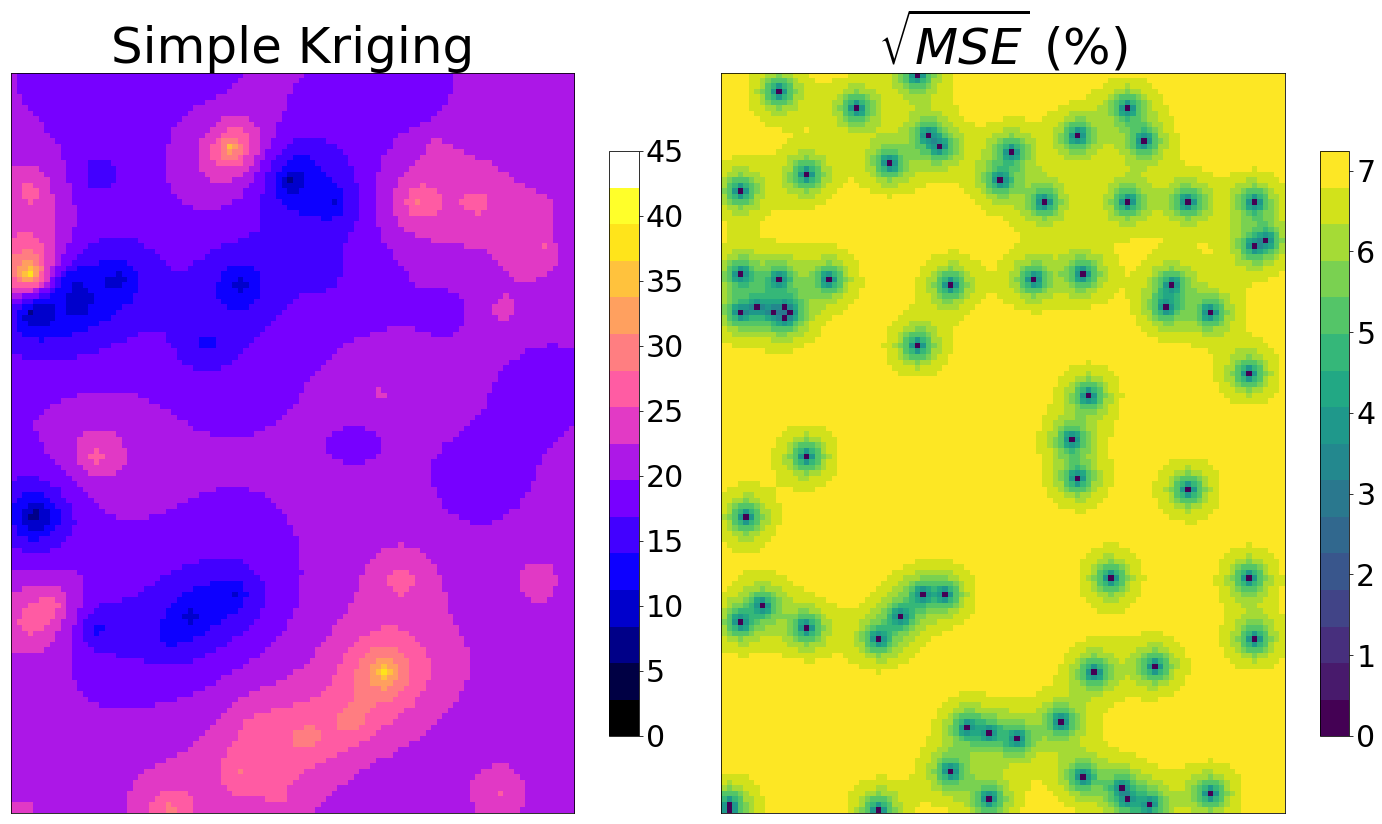

In [39]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(ypred_sk.reshape(data.shape),cmap=cm.get_cmap('gnuplot2',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Simple Kriging',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(122)
plt.imshow(mse.reshape(data.shape)**0.5,cmap=cm.get_cmap('viridis',16))
plt.xticks([])
plt.yticks([])
plt.title(r'$\sqrt{MSE}$ (%)',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

Kriging gives us the parameters for the localized posteriors:
    
* The Kriging estimate gives us the mean
* The Kriging variance gives us the variance

# Kriging: Local posteriors

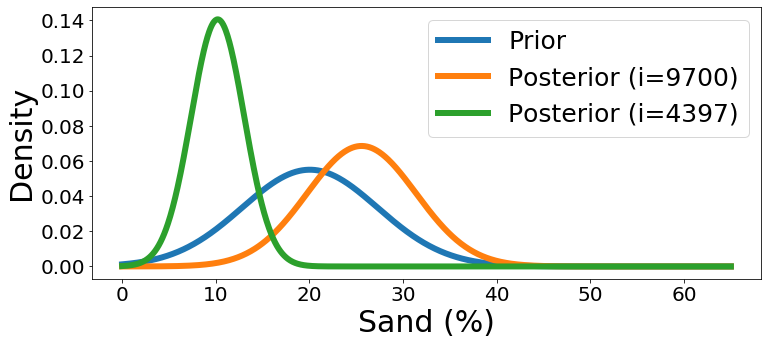

In [40]:
mu = np.mean(yt) #% sand
var = vgfit[0] #%^2 sand
xpdf = np.linspace(0,65,1000)
plt.figure(figsize=(12,5))
plt.plot(xpdf,scipy.stats.norm.pdf(xpdf,loc=mu,scale=var**0.5),lw=6)
plt.plot(xpdf,scipy.stats.norm.pdf(xpdf,loc=ypred[9700],scale=mse[9700]**0.5),lw=6)
plt.plot(xpdf,scipy.stats.norm.pdf(xpdf,loc=ypred[4397],scale=mse[4397]**0.5),lw=6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Density',fontsize=30)
plt.xlabel('Sand (%)',fontsize=30)
plt.legend(['Prior','Posterior (i=9700)','Posterior (i=4397)'],fontsize=25)
plt.show()

# How could we use the posterior data to create a random map?

Another way to see this is determining how to sample from the $n$ dimensional posterior distribution. We want to create a random realization of the map. 

As you will see, this ensures that the recreated map maintains the spatial properties (semivariogram) computed from the in-situ data.

# Sequential Gaussian Simulation

Following Webster et al., 2007, to implement the technique the following are the steps needed.

1. Ensure that the data are approximately normal; transform to a standard normal distribution if necessary.
2. Compute and model the semivariogram.
3. Specify the coordinates of the points at which you want to simulate on a grid.
4. Determine the random sequence in which the points, $\mathbf{x}_i$; $i = 1,2,..,N$ will be visited for the simulation.
5. Simulate at each of these points as follows.
    * Use simple kriging with the semivariogram model to obtain $z^*$ and $\sigma_K^2$.
    * Draw a value at random from a Gaussian where $\mu = z^*$ and $\sigma^2 = \sigma_K^2$.
    * Insert this value into the grid at $\mathbf{x}_i$, and add it to the data.
    * Proceed to the next node and simulate the value at this point in the grid.
    * Repeat steps (a) to (c) until all of the nodes have been simulated.
6. Back-transform the simulated values if there is a need to.

# Sequential Gaussian Simulation

In [41]:
def simple_kriging_point(range,sill,xo,yo,do,x,y):
    
    #Compute weights
    # Compute distance matrix between all points and all observations
    h = ((xo - x)**2 + (yo - y)**2)**0.5
    # Compute covariance of unknown points with data
    c = sill*np.exp(-h/range).T
    # Compute covariance of all observations with each other
    h = ((xo[:,np.newaxis] - xo[:,np.newaxis].T)**2 + (yo[:,np.newaxis] - yo[:,np.newaxis].T)**2)**0.5
    Sigma = sill*np.exp(-h/range)
    # Solve for the weights
    weights = np.linalg.solve(Sigma,c)
    #Compute zstar
    zstar = np.sum(weights*do)
    #Compute mse 
    mse = sill - np.sum(weights*c,axis=0)
    
    return (zstar,mse)

In [42]:
#1. Transform to standard normal distribution
std = np.std(yt)
mean = np.mean(yt)
yt_scaled = (yt- mean)/std

In [43]:
#2. Compute and model the semivariogram
#Compute sample semivariogram
(hd,gamma_s) = sample_variogram(x_points,y_points,yt_scaled)
#Fit exponential semivariogram
vgfit = fit_exponential_semivariogram(hd,gamma_s)

In [44]:
#3. Specify the points
#Define the meshgrid
(x_grid,y_grid) = np.meshgrid(x,y)
#Define grid positioning
#Let's reshape our data to a 1d array
xg1d = x_grid.reshape(x_grid.size)
yg1d = y_grid.reshape(y_grid.size)

In [45]:
#4. Determine order of simulation
#Create random path through the data
ipoints = np.arange(xg1d.size)
#Remove points that already have data (necessary for conditioning)
h = ((x_points - xg1d[:,np.newaxis])**2 + (y_points - yg1d[:,np.newaxis])**2)**0.5
ipoints_obs = np.argmin(h,axis=0)
msgs = np.zeros(ipoints.size).astype(np.bool)
msgs[ipoints_obs] = 1
ipoints = ipoints[~msgs]
#Shuffle the remaining points
np.random.seed(1)
np.random.shuffle(ipoints)
#Move through the points to perform sequential gaussian simulation
sgs = {'x':x_points[:],'y':y_points[:],'data':yt_scaled[:],'ip':ipoints_obs[:]}

In [46]:
#Perform sequential gaussian simulation
n = 10
for ipoint in ipoints:
    #Extract the closes n points
    h = ((xg1d[ipoint] - sgs['x'])**2 + (yg1d[ipoint] - sgs['y'])**2)**0.5
    msgs = np.argsort(h)[0:n]
    #Use simple kriging to predict at the point
    (zstar,mse) = simple_kriging_point(vgfit[1],vgfit[0],sgs['x'][msgs],sgs['y'][msgs],
                                       sgs['data'][msgs],xg1d[ipoint],yg1d[ipoint])
    #Draw a value from the distribution defined by the mse
    zest = np.random.normal(loc=zstar,scale=mse**0.5)
    #Add point to data 
    sgs['x'] = np.append(sgs['x'],xg1d[ipoint])
    sgs['y'] = np.append(sgs['y'],yg1d[ipoint])
    sgs['data'] = np.append(sgs['data'],zest)
    sgs['ip'] = np.append(sgs['ip'],ipoint)
    

In [47]:
#Order and backtransform data
argsort = np.argsort(sgs['ip'])
ypred_scaled = sgs['data'][argsort].reshape(x_grid.shape)
ypred = ypred_scaled*std + mean

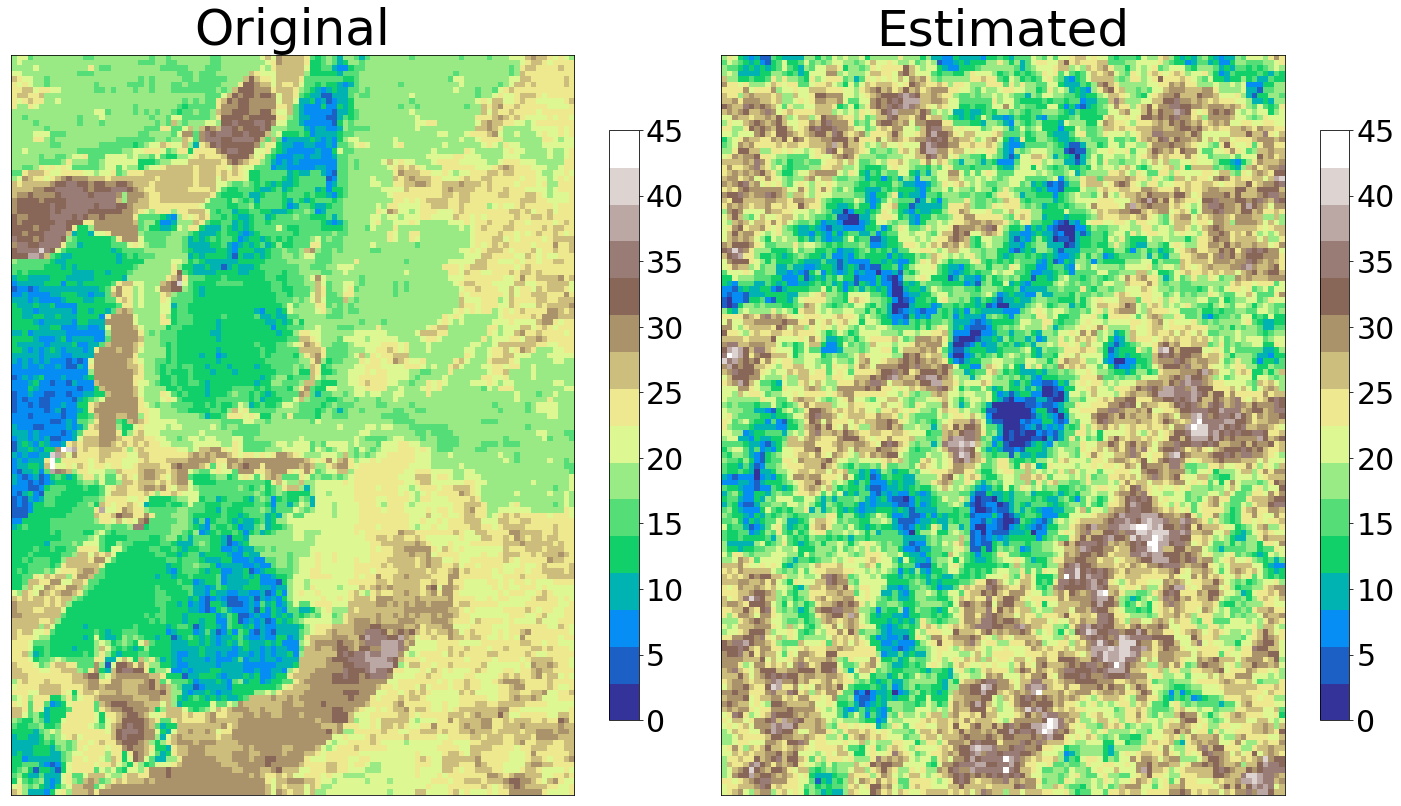

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(ypred,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Estimated',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(data,cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

In [50]:
yv_pred = ypred.reshape(ypred.size)[~m]
print('R2: %.2f' % sklearn.metrics.r2_score(yv,yv_pred))

R2: -0.87


Well that is terrible. So what's the point?

Reproducing the spatial properties of computed semivariogram

# Let's look at an ensemble of simulations

In [51]:
def simple_kriging_point(range,sill,xo,yo,do,x,y):
    
    #Compute weights
    # Compute distance matrix between all points and all observations
    h = ((xo - x)**2 + (yo - y)**2)**0.5
    # Compute covariance of unknown points with data
    c = sill*np.exp(-h/range).T
    # Compute covariance of all observations with each other
    xo1 = xo.reshape((xo.size,1))
    yo1 = yo.reshape((yo.size,1))
    h = ((xo1 - xo1.T)**2 + (yo1 - yo1.T)**2)**0.5
    Sigma = sill*np.exp(-h/range)
    # Solve for the weights
    weights = np.linalg.solve(Sigma,c)
    #Compute zstar
    zstar = np.sum(weights*do)
    #Compute mse 
    mse = sill - np.sum(weights*c,axis=0)
    
    return (zstar,mse)

def sgs_main(xg1d,yg1d,x,y,dp,ip,ipoints,ipos):
    n = 10
    maxd = 5000
    for ipoint in ipoints:
        #Extract the closest n points
        tic = time.time()
        h = ((xg1d[ipoint] - x[:ipos])**2 + (yg1d[ipoint] - y[:ipos])**2)**0.5
        idx = np.where(h < maxd)[0] #Get only those that are within a certain radius
        m = idx[np.argsort(h[idx])][0:n] #Get the lowest n
        #Use simple kriging to predict at the point
        (zstar,mse) = simple_kriging_point(vgfit[1],vgfit[0],x[:ipos][m],y[:ipos][m],
                                           dp[:ipos][m],xg1d[ipoint],yg1d[ipoint])
        #Draw a value from the distribution defined by the mse
        zest = np.random.normal(loc=zstar,scale=mse**0.5)
        #Add point to data 
        dp[ipos] = zest
        #Update position
        ipos+=1
    return(x,y,dp,ip)

def sequential_gaussian_simulation(yt,x,y,x_points,y_points,seed=1):
    
    #1. Transform to standard normal distribution
    std = np.std(yt)
    mean = np.mean(yt)
    yt_scaled = (yt- mean)/std
    
    #2. Compute and model the semivariogram
    #Compute sample semivariogram
    (hd,gamma_s) = sample_variogram(x_points,y_points,yt_scaled)
    #Fit exponential semivariogram
    vgfit = fit_exponential_semivariogram(hd,gamma_s)
    
    #3. Specify the points
    #Define the meshgrid
    (x_grid,y_grid) = np.meshgrid(x,y)
    #Define grid positioning
    #Let's reshape our data to a 1d array
    xg1d = x_grid.reshape(x_grid.size)
    yg1d = y_grid.reshape(y_grid.size)
    
    #4. Determine order of simulation
    #Create random path through the data
    ipoints = np.arange(xg1d.size)
    #Remove points that already have data (necessary for conditioning)
    h = ((x_points - xg1d[:,np.newaxis])**2 + (y_points - yg1d[:,np.newaxis])**2)**0.5
    ipoints_obs = np.argmin(h,axis=0)
    m = np.zeros(ipoints.size).astype(np.bool)
    m[ipoints_obs] = 1
    ipoints = ipoints[~m]
    #Shuffle the remaining points
    np.random.seed(seed)
    np.random.shuffle(ipoints)
    #Move through the points to perform sequential gaussian simulation
    sgs = {'x':np.concatenate((x_points,xg1d[ipoints])),
           'y':np.concatenate((y_points,yg1d[ipoints])),
           'data':np.concatenate((yt_scaled,np.zeros(ipoints.size))),
           'ip':np.concatenate((ipoints_obs,ipoints))}
    iinit = ipoints_obs.size
    
    #5. Perform sequential gaussian simulation
    (sgs['x'],sgs['y'],sgs['data'],sgs['ip']) = sgs_main(xg1d,yg1d,sgs['x'],sgs['y'],sgs['data'],
                                                         sgs['ip'],ipoints,iinit)
        
    #6. Order and backtransform data
    argsort = np.argsort(sgs['ip'])
    ypred_scaled = sgs['data'][argsort].reshape(x_grid.shape)
    ypred = ypred_scaled*std + mean
    
    return ypred

In [52]:
import time
ypred_ensemble = []
for isim in range(25):
    print(isim)
    tic = time.time()
    ypred_ensemble.append(sequential_gaussian_simulation(yt,x,y,x_points,y_points,isim))
    print(time.time()-tic)

0
3.3908393383026123
1
3.347548723220825
2
3.3047752380371094
3
3.4037697315216064
4
3.331172227859497
5
3.317840814590454
6
3.327608108520508
7
3.4123053550720215
8
3.3881170749664307
9
3.553629159927368
10
3.6079695224761963
11
3.6577963829040527
12
3.4218735694885254
13
3.3202333450317383
14
3.304908514022827
15
3.337249279022217
16
3.510424852371216
17
3.578547477722168
18
3.5469744205474854
19
3.6731269359588623
20
3.5722081661224365
21
3.421893358230591
22
3.350252389907837
23
3.404940605163574
24
3.35102915763855


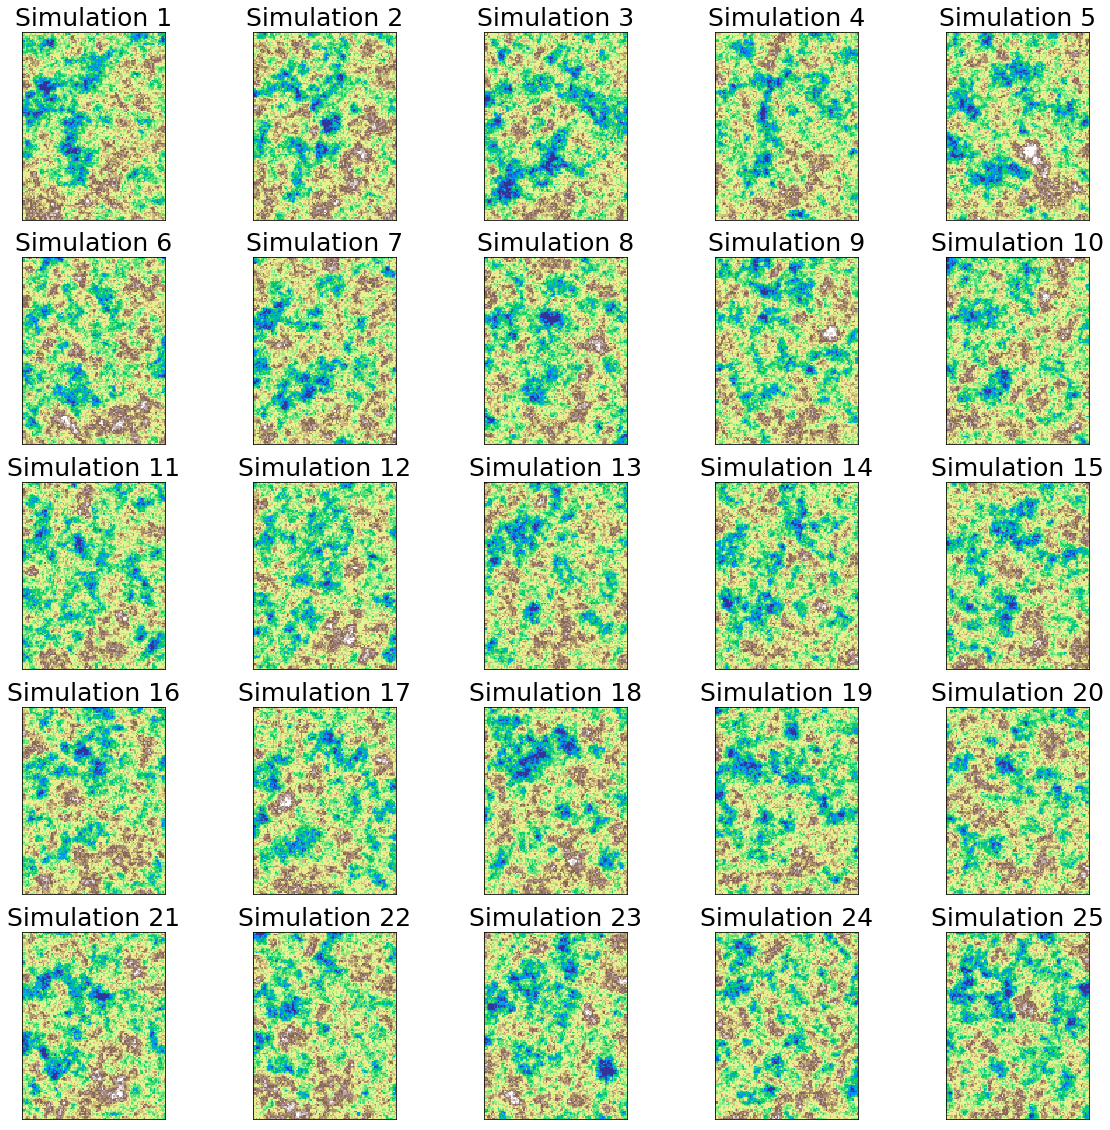

In [55]:
#Plot the 25 maps
plt.figure(figsize=(20,20))
for i in range(len(ypred_ensemble)):
    plt.subplot(5,5,i+1)
    plt.imshow(ypred_ensemble[i],cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    plt.title('Simulation %d' % (i+1),fontsize=25)
plt.show()

# Average over the 25 ensemble members

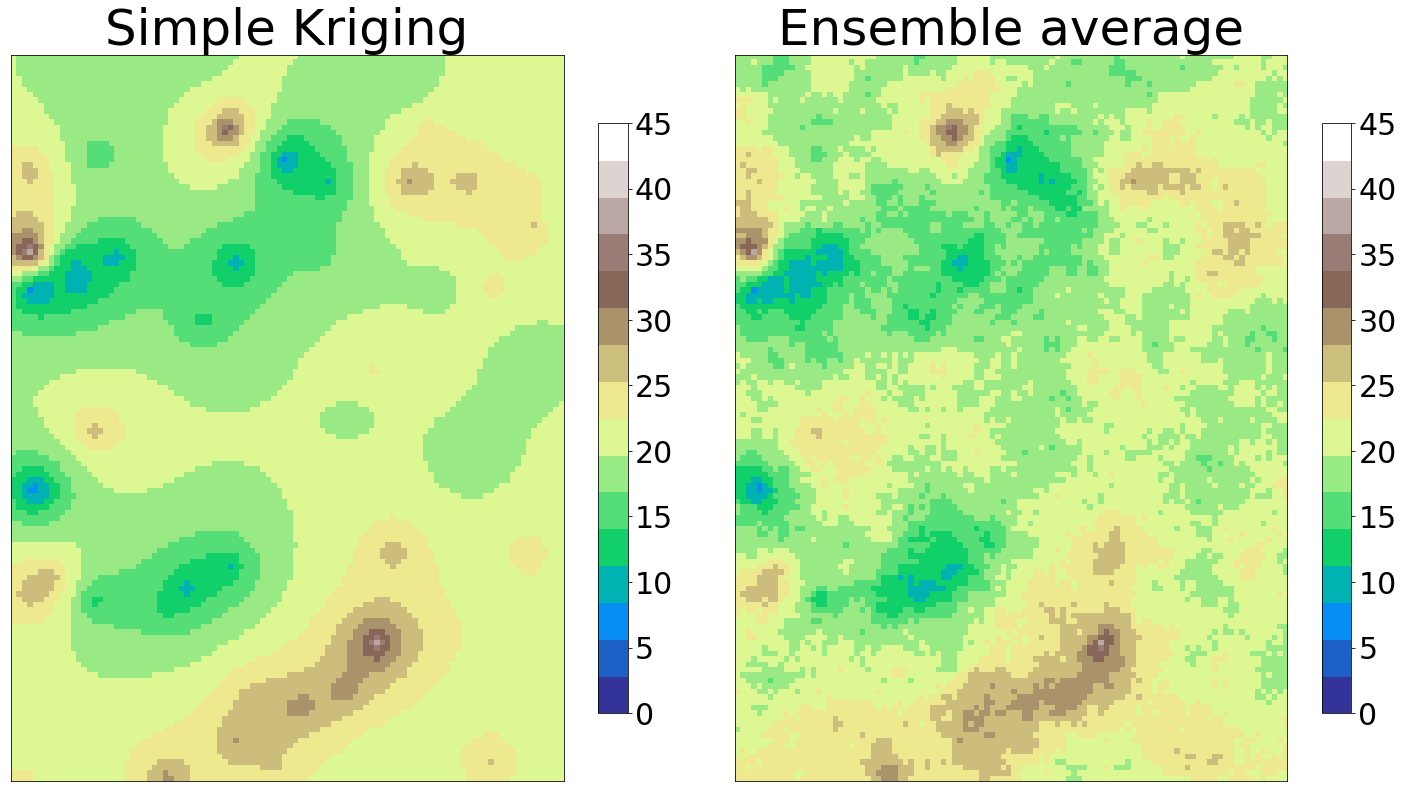

In [56]:
ypred_ensemble = np.array(ypred_ensemble)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
vmin = 0
vmax = 45
#Plot the original and kriged data side by side
plt.figure(figsize=(20,12))
plt.subplot(122)
plt.imshow(np.mean(ypred_ensemble,axis=0),cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Ensemble average',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.subplot(121)
plt.imshow(ypred_sk.reshape(data.shape),cmap=cm.get_cmap('terrain',16),vmin=vmin,vmax=vmax)
plt.xticks([])
plt.yticks([])
plt.title('Simple Kriging',fontsize=50)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=30)
plt.tight_layout()
plt.show()

If we keep increasing the number of simulations, what will we eventually converge to? 

# You can imagine combining Regression Kriging and Conditional simulations

Although there are important differences, the combination of the two has strong similarities to how the initial conditions of numerical weather models are perturbed.

If you start digging into Kalman Filters, Ensemble Kalman Filters, 3DVar and 4DVar, you will see many analogies to what we have be discussing.

# And that's it for Geostatistics...